In [67]:
import tensorflow as tf
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd

# Load and preprocess data

In [68]:
def load_data(data_path = "dataF8k/captions.txt"):
    return pd.read_csv(data_path, header = 0)

data = load_data()
print("number of captions:", data.shape[0])
# data.head()

number of captions: 40455


## Prepare captions

In [69]:
# add unique start word ">>>" (stop word = "." already present in data)
data["caption_with_start"] = ">>> " + data["caption"].str.lower()
# data.head()

In [70]:
# Tokenize captions, keeping all words that appear at least 5 times
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '') # don't filter punctuation
tokenizer.fit_on_texts(data["caption_with_start"])

count_thres = 5
low_count_words = [w for w,c in tokenizer.word_counts.items() if c < count_thres]
for w in low_count_words:
    del tokenizer.word_index[w]
    del tokenizer.word_docs[w]
    del tokenizer.word_counts[w]

data["token_caption"] = tokenizer.texts_to_sequences(data["caption_with_start"])

data.head()

,image,caption,caption_with_start,token_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,>>> a child in a pink dress is climbing up a s...,"[2, 1, 43, 4, 1, 91, 171, 7, 120, 54, 1, 397, ..."
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,>>> a girl going into a wooden building .,"[2, 1, 19, 316, 65, 1, 195, 118, 3]"
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,>>> a little girl climbing into a wooden playh...,"[2, 1, 41, 19, 120, 65, 1, 195, 2437, 3]"
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,>>> a little girl climbing the stairs to her p...,"[2, 1, 41, 19, 120, 5, 394, 21, 61, 2437, 3]"
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,>>> a little girl in a pink dress going into a...,"[2, 1, 41, 19, 4, 1, 91, 171, 316, 65, 1, 195, 3]"


In [73]:
#get maximum number of words in data. 
data["caption_len"] = data["token_caption"].str.len()
max_len = data["caption_len"].max(axis = 0)
print("Maximum caption length:", max_len)
max_len = 40

# get size of vocabulary
vocab_size = len(tokenizer.word_counts)
print("Vocabulary size:", vocab_size)

Maximum caption length: 38
Vocabulary size: 3002


In [74]:
# Transform data into arrays
image = data["image"].to_numpy()
caption_tok = np.array(data["token_caption"])

## Image encoding with pretrained CNN model

In [75]:
# Import CNN model and labels
cnn = tf.keras.applications.inception_v3.InceptionV3()

labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
labels = np.array(open(labels_path).read().splitlines())

(1, 1000)
[0.7300238  0.05839121 0.05084527 0.04995775 0.00733737]
['motor scooter' 'monitor' 'crane' 'eggnog' 'bib']


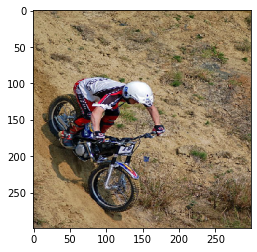

In [76]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Test on an image
img = load_img("dataF8k/Images/479807115_3a484fb18b.jpg", target_size=(299, 299))
plt.imshow(img)
x = img_to_array(img) 
x = x.reshape((1,) + x.shape) 

x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

predictions = cnn.predict(x)
print(predictions.shape)
top_5_classes_index = np.argsort(predictions)[0 , ::-1][:5]
print(predictions[0,top_5_classes_index])
top_5_classes = labels[top_5_classes_index]
print(top_5_classes)

In [77]:
from tensorflow.keras.models import Model

# remove last layer for our encoder
cnn._layers.pop() # Get rid of the classification layer
cnn4nw = Model(inputs=cnn.inputs, outputs=cnn.layers[-1].output)

print("Output shape:", cnn4nw.layers[-1].output_shape)

Output shape: (None, 2048)


(2048,)


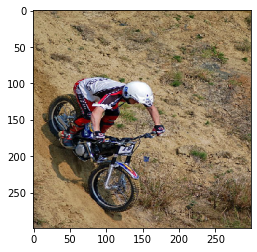

In [78]:
# Test on an image
img = load_img("dataF8k/Images/479807115_3a484fb18b.jpg", target_size=(299, 299))
plt.imshow(img)
x = img_to_array(img) 
x = x.reshape((1,) + x.shape) 
x = tf.keras.applications.inception_v3.preprocess_input(x)
prediction = cnn4nw.predict(x)
prediction.shape
prediction = prediction.reshape(2048)
print(prediction.shape)

In [79]:
#'Encode' images to vectors using CNN
from tqdm import tqdm

try:
    image_enc = np.load('image_enc.npy')
except:
    image_enc = []
    for i in tqdm(range(len(image))):
        if i == 0 or image[1] != image[i-1]:
            image_path = "dataF8k/Images/" + image[i]
            img = load_img(image_path, target_size=(299, 299))
            x = img_to_array(img) 
            x = x.reshape((1,) + x.shape) 
            x = tf.keras.applications.inception_v3.preprocess_input(x)
            prediction = cnn4nw.predict(x)
            prediction = prediction.reshape(2048)
            image_enc.append(prediction)
        else: 
            image_enc.append(image_enc[i-1])
    np.save('image_enc.npy', image_enc)

## Functions to prepare data for model

In [80]:
def pad_zeros(caption, max_len):
    # zero-padding of caption
    cap = np.zeros(max_len)
    cap[:len(caption)] = caption
    return cap

In [96]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

'''
	*Each caption will be split into words. The model will be provided one word & the image and it generates the next word. 
	*Then the first two words of the caption will be provided to the model as input with the image to generate the next word. 
	*This is how the model will be trained.
	*For example, the input sequence “little girl running in field” would be 
		split into 6 input-output pairs to train the model:

		X1		X2(text sequence) 								y(word)
		-----------------------------------------------------------------
		image	startseq,										little
		image	startseq, little,								girl
		image	startseq, little, girl,							running
		image	startseq, little, girl, running,				in
		image	startseq, little, girl, running, in,			field
		image	startseq, little, girl, running, in, field,		endseq
'''
# Create input/target sequences of image, input sequence and output words for one image/caption combination
def create_sequences(vocab_size, max_length, caption, image):
    # vocab_size, max_length: int
    # caption: tokenized array of caption
    # image: CNN encoded array of size 2048 of image
    # X1 : input for image features
    # X2 : input for text features
    # y  : output word
    X1, X2, y = list(), list(), list()
    # Split sequence into multiple X,y pairs
    for i in range(1, len(caption)):
        # Split into input and output pair
        in_seq, out_seq = caption[:i], caption[i]
        # Pad input sequence
        in_seq = pad_sequences([in_seq], max_length)[0]
        # Encode output sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        # Store
        X1.append(image)
        X2.append(in_seq)
        y.append(out_seq)
    return X1, X2, y



In [97]:
import random

# Data generator, intended to be used in a call to model.fit_generator()
# X1 shape : sum(caption in batch)[caption_length-1] x 2048
# X2 shape : sum(caption in batch)[caption_length-1] x max_len
# y shape  : sum(caption in batch)[caption_length-1] x vocab_size
def data_generator(images, captions, max_length, vocab_size, batch_size, random_seed = 4353):
    # Setting random seed for reproducibility of results
    random.seed(random_seed)

    index_list = np.arange(len(captions))
    random.shuffle(index_list)

    assert batch_size<= len(captions), 'Batch size must be less than or equal to {}'.format(len(captions))

    _count=0

    while True:
        if _count >= len(captions):
            # Generator exceeded or reached the end so restart it
            _count = 0
            # shuffle indices for next round
            random.shuffle(index_list)
        # Batch list to store data
        input_img_batch, input_sequence_batch, output_word_batch = list(), list(), list()
        for i in range(_count, min(len(index_list), _count+batch_size)):
            index = index_list[i]
            # Retrieve the image features
            image = images[index]
            # Retrieve the caption
            caption = captions[index]
            input_img, input_sequence, output_word = create_sequences(vocab_size, max_length, caption, image)
            # Add to batch
            for j in range(len(input_img)):
                input_img_batch.append(input_img[j])
                input_sequence_batch.append(input_sequence[j])
                output_word_batch.append(output_word[j])
        _count = _count + batch_size
        yield ([np.array(input_img_batch), np.array(input_sequence_batch)], np.array(output_word_batch))

# Model setup

In [98]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding, concatenate

def RNNModel(vocab_size, max_len, rnnConfig):
    embedding_size = 512
    image_input = Input(shape = (2048,))
    image_model_1 = Dropout(rnnConfig['dropout'])(image_input)
    image_model = Dense(embedding_size, activation='relu')(image_input)

    caption_input = Input(shape=(max_len,))
    # mask_zero: We zero pad inputs to the same length, the zero mask ignores those inputs. E.g. it is an efficiency.
    caption_model_1 = Embedding(vocab_size, embedding_size, mask_zero=True)(caption_input)
    caption_model_2 = Dropout(rnnConfig['dropout'])(caption_model_1)
    caption_model = LSTM(rnnConfig['LSTM_units'])(caption_model_1)

    # Merging the models and creating a softmax classifier
    final_model_1 = concatenate([image_model, caption_model])
    # final_model_2 = Dense(rnnConfig['dense_units'], activation='relu')(final_model_1)
    final_model = Dense(vocab_size, activation='softmax')(final_model_1)

    model = Model(inputs=[image_input, caption_input], outputs=final_model)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model 

# Execute

In [100]:
# make model
rnnConfig = {
	'embedding_size': 512,
	'LSTM_units': 512,
	# 'dense_units': 600,
	'dropout': 0.4
}
model = RNNModel(vocab_size, max_len, rnnConfig)

In [105]:
# make generator
generator = data_generator(image_enc, caption_tok, max_len, vocab_size, 32)

In [108]:
history = model.fit(generator, epochs = 1000, steps_per_epoch = 112)

112/112 [==============================] - 32s 283ms/step - loss: 4.0567


In [ ]:
model.save('trained_model')